In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.classifier import BinaryClassifier
import torch
from torch.utils.data import TensorDataset
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
from models.flow import Flow
# from models.fair import BinaryFair
from models.my_fair import BinaryFair
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from models.galton import Galton
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2


## Generate Split Data 

### Baseline High-Res Simulator 

In [2]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True}

data, labels, context = gen_galton_data(1, 100, sigma=0.4)
data_train, data_test, labels_train, labels_test, context_train, context_test = train_test_split(data, labels, context, test_size=0.1) 
data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

In [3]:
label_classifier = BinaryClassifier(1)
label_classifier.fit(data_generator_labels_train)
label_classifier.accuracy(data_test,labels_test)

100%|██████████| 10000/10000 [00:16<00:00, 605.77it/s]


0.6349999904632568

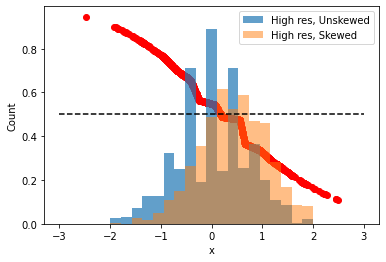

In [4]:
plt.hist(np.array(data_test[labels_test==1]),bins=np.linspace(-2,2,20), alpha=0.7, label="High res, Unskewed", density=True)
plt.hist(np.array(data_test[labels_test==0]),bins=np.linspace(-2,2,20), alpha=0.5, label="High res, Skewed", density=True)
plt.xlabel("x")
plt.ylabel("Count")
plt.legend()
plt.scatter(data_test.detach().numpy(), label_classifier.forward(data_test).sigmoid().detach().numpy(), color='red') #Sigmoid for density comparison

plt.plot(np.linspace(-3,3,100), 0.5*np.ones(100), 'k--')

plt.show()

## Introducing Fair Flows

### Probability Flow

In [5]:
#Treating this probability flow as part of the data generation process. Samples from p_0, p_1
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=data_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )
optimizer = torch.optim.AdamW(probability_flow.parameters(), lr=1e-4, weight_decay=1e-4)

In [6]:
data_set_context_train = TensorDataset(data_train, context_train) #For probability flow, learn distributions conditioned on context
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_labels_train = TensorDataset(data_train, labels_train) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

In [7]:
n_steps_prob = 4000
probability_loss = []

probability_flow.train()
for n_step in trange(n_steps_prob):
    data, context = next(iter(data_generator_context_train))
    context=context.unsqueeze(1)

    optimizer.zero_grad()

    loss = -probability_flow.log_prob(inputs=data, context=context).mean()
    probability_loss.append(loss.item())

    loss.backward()
    optimizer.step()
probability_flow.eval();

100%|██████████| 4000/4000 [00:48<00:00, 82.20it/s]


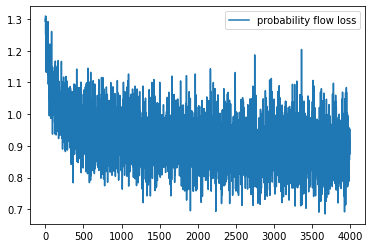

In [8]:
plt.plot(probability_loss, label="probability flow loss")
plt.legend()
plt.show()

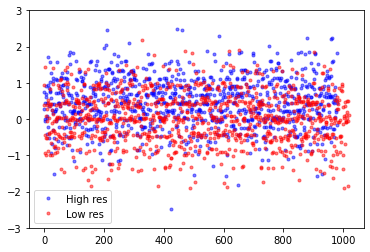

In [9]:
plt.plot(data_test[context_test==1],'b.',label="High res", alpha=0.5)
plt.plot(data_test[context_test==0], 'r.', label="Low res", alpha=0.5)
plt.ylim(-3, 3)
plt.legend()
plt.show()

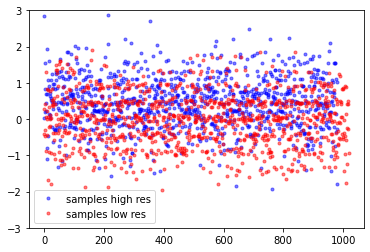

In [10]:
samples = probability_flow._sample(num_samples=1, context=context_test.unsqueeze(1))
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==1], 'b.', alpha=0.5, label="samples high res")
plt.plot(samples.squeeze().detach().numpy()[context_test.squeeze().numpy()==0], 'r.', alpha=0.5, label="samples low res")
plt.ylim(-3, 3)
plt.legend()
plt.show()

### Fair Normalizing Flows

In [11]:
label_0_train_generator, label_1_train_generator, label_0_test_generator, label_1_test_generator = get_fair_generators(data_train, labels_train, context_train, data_test, labels_test, context_test)

In [12]:
#Get label accuracy on raw data
#TODO: Calculate analytic accuracy based on overlap of (Gaussian?) distributions
label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train)
label_classifier.accuracy(data_test, labels_test)

100%|██████████| 10000/10000 [00:17<00:00, 569.02it/s]


0.640500009059906

In [13]:
#Create and train fair normalizing flows
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=data_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    Fair.fit(label_0_train_generator, label_1_train_generator, probability_flow, n_steps=100) #4000 is good for now

    Fairs.append(Fair)


100%|██████████| 100/100 [00:08<00:00, 11.72it/s]


In [14]:
#Calculate Statistical Distances
stat_dists = []
for fair in Fairs:
    stat_dist, _, _ = fair.optimal_adversary(label_0_test_generator, label_1_test_generator, probability_func=probability_flow)
    stat_dists.append(abs(stat_dist)) #? why is the statistical distance negative? Should go over this calculation again to see if this makes sense
print(stat_dists)

[tensor(1.), tensor(0.9786), tensor(0.2416), tensor(0.2661), tensor(0.2538)]


In [15]:
#Calculate embedded label accuracy and adversarial accuracy
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train, context_train, data_test, labels_test, context_test, fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator, n_steps=100)
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator, n_steps=100)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))

100%|██████████| 100/100 [00:00<00:00, 582.26it/s]


In [16]:
#I believe these should be the same for alpha=1, complete correlation.
print("label accuracy: ", embedded_label_accs, "\nadversary accuracy: ", adversary_accs)

label accuracy:  [1.0, 0.9884999990463257, 0.5105000138282776, 0.4925000071525574, 0.527999997138977] 
adversary accuracy:  [1.0, 0.9710000157356262, 0.5274999737739563, 0.5095000267028809, 0.49050000309944153]


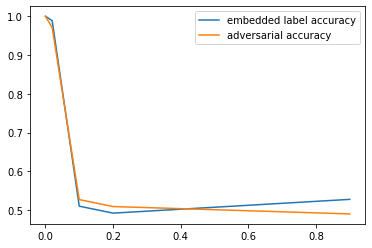

In [18]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='adversarial accuracy')
plt.legend()
plt.show()
